<a href="https://colab.research.google.com/github/itsThien/ITAI/blob/main/CineSenti_Exploring_Movie_Sentiment_with_Word2Vec%2C_TF_IDF_%26_FastText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB Sentiment — Word2Vec pipeline (Colab-ready)

This notebook is designed for **interpretability and clarity**. It walks through:
- Downloading the IMDB 50k reviews dataset
- Cleaning and tokenizing text (with explanations)
- Training Word2Vec embeddings (with helpful parameters and tips)
- Inspecting and visualizing embeddings
- Using averaged embeddings for a simple classifier (Logistic Regression)
- Improvements: stopword removal, lemmatization, tqdm progress bars, model saving

Run each cell in order. Comments and explanations are included for learning.

## 1) Install libraries

Install required libraries. In Colab these installs are safe to run.

In [1]:
# Install a compatible numpy version first
!pip install --quiet numpy==1.26.4

# Install other libraries
!pip install --quiet kagglehub gensim tqdm nltk scikit-learn matplotlib seaborn umap-learn

# Download NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 2) Download dataset

Use `kagglehub` for importing the dataset

In [2]:
import kagglehub
from pathlib import Path

print('Downloading dataset... this may take a moment')
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print('Dataset downloaded to:', path)

# locate the CSV (common name: IMDB Dataset.csv)
csv_path = None
for p in Path(path).rglob('*.csv'):
    csv_path = str(p)
    break

if csv_path is None:
    raise FileNotFoundError('Could not find CSV in downloaded path. Check contents of ' + str(path))

print('Using CSV:', csv_path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Dataset downloaded to: /kaggle/input/imdb-dataset-of-50k-movie-reviews
Using CSV: /kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


## 3) Load and inspect the data

Rename columns to `text` and `label` for clarity.

In [3]:
import pandas as pd

df = pd.read_csv(csv_path)
print('Original columns:', df.columns.tolist())
# standardize column names if necessary
if len(df.columns) >= 2:
    df = df.iloc[:, :2]
    df.columns = ['text', 'label']

print(df.head())
print('\nLabel distribution:\n', df['label'].value_counts())

Original columns: ['review', 'sentiment']
                                                text     label
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Label distribution:
 label
positive    25000
negative    25000
Name: count, dtype: int64


## 4) Text cleaning

Steps:
- lowercase
- remove URLs
- remove punctuation and numbers
- remove extra spaces
- remove stopwords and lemmatize (for better interpretability)


In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def clean_text(text, remove_stopwords=True, do_lemmatize=True):
    # lowercase
    text = str(text).lower()
    # remove urls
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # remove non-alpha (keep spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # collapse spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # tokenize simply
    tokens = text.split()
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Apply cleaning with tqdm to watch progress
tqdm.pandas()
df['clean_text'] = df['text'].progress_apply(lambda x: clean_text(x))
# token column
df['tokens'] = df['clean_text'].apply(lambda x: x.split())

print(df[['text','clean_text','tokens']].head())

100%|██████████| 50000/50000 [01:06<00:00, 753.56it/s] 


                                                text  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                          clean_text  \
0  one reviewer mentioned watching oz episode hoo...   
1  wonderful little production br br filming tech...   
2  thought wonderful way spend time hot summer we...   
3  basically family little boy jake think zombie ...   
4  petter mattei love time money visually stunnin...   

                                              tokens  
0  [one, reviewer, mentioned, watching, oz, episo...  
1  [wonderful, little, production, br, br, filmin...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, family, little, boy, jake, think, ...  
4  [petter, mattei, love, time, money, visually, ..

**Note:** Used a fast whitespace tokenizer after cleaning for clarity and reproducibility. You can swap in `nltk.word_tokenize` or a subword tokenizer if you want more linguistic nuance.

## 5) Train Word2Vec embeddings

Using `gensim.models.Word2Vec`. Parameters are chosen to balance speed and quality.

In [5]:
from gensim.models import Word2Vec

sentences = df['tokens'].tolist()

w2v_params = {
    'vector_size': 150,   # embedding dimension
    'window': 5,          # context window
    'min_count': 3,       # ignore rare words
    'workers': 4,
    'epochs': 15,
    'sg': 1               # skip-gram (better for smaller datasets / rare words)
}

print('Training Word2Vec with params:', w2v_params)
w2v = Word2Vec(sentences=sentences, **w2v_params)

# save model
w2v.save('w2v_imdb_improved.model')
print('Saved model to w2v_imdb_improved.model')

Training Word2Vec with params: {'vector_size': 150, 'window': 5, 'min_count': 3, 'workers': 4, 'epochs': 15, 'sg': 1}
Saved model to w2v_imdb_improved.model


## 6) Analyze embeddings — nearest neighbors

Try a few words and inspect nearest neighbors. This helps qualitatively evaluate embedding quality.

In [6]:
examples = ['good', 'movie', 'team', 'great', 'bad']
for word in examples:
    if word in w2v.wv:
        print(f"\nMost similar to '{word}':")
        for sim_word, score in w2v.wv.most_similar(word, topn=10):
            print(f"  {sim_word}\t{score:.3f}")
    else:
        print(f"\n'{word}' not in vocabulary")


Most similar to 'good':
  decent	0.748
  great	0.737
  bad	0.704
  nice	0.674
  ok	0.670
  hella	0.666
  excellent	0.660
  unbelieveable	0.658
  fine	0.648
  kamerling	0.645

Most similar to 'movie':
  film	0.844
  flick	0.731
  havn	0.726
  atleast	0.710
  schindlers	0.705
  bleh	0.703
  tpb	0.698
  sence	0.692
  havent	0.687
  dcom	0.685

Most similar to 'team':
  bucuresti	0.636
  steaua	0.631
  zephyr	0.595
  hoper	0.562
  nhl	0.561
  lambeau	0.553
  drillers	0.552
  mnm	0.544
  ragtag	0.542
  permian	0.541

Most similar to 'great':
  wonderful	0.774
  excellent	0.770
  terrific	0.750
  good	0.737
  fantastic	0.717
  amazing	0.695
  outstanding	0.672
  fine	0.668
  superb	0.661
  brilliant	0.658

Most similar to 'bad':
  terrible	0.760
  awful	0.728
  horrible	0.716
  good	0.704
  smirked	0.643
  sed	0.640
  lousy	0.637
  apalling	0.632
  kamerling	0.631
  soooooooo	0.629


## 7) Visualize embeddings (PCA + UMAP)

Visualize a selected set of words using PCA and UMAP for a clearer 2D representation. UMAP often preserves neighborhood structure well.

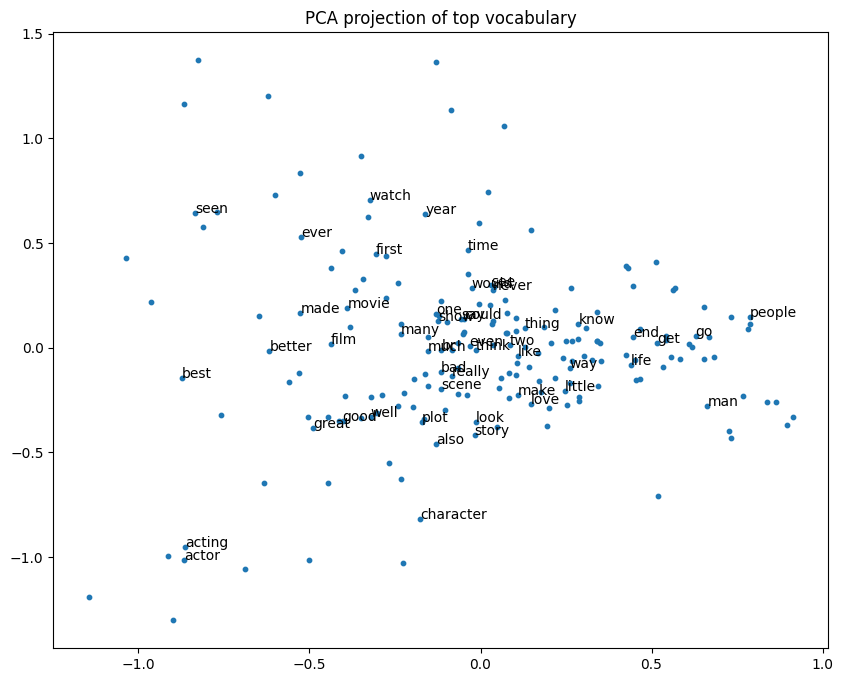

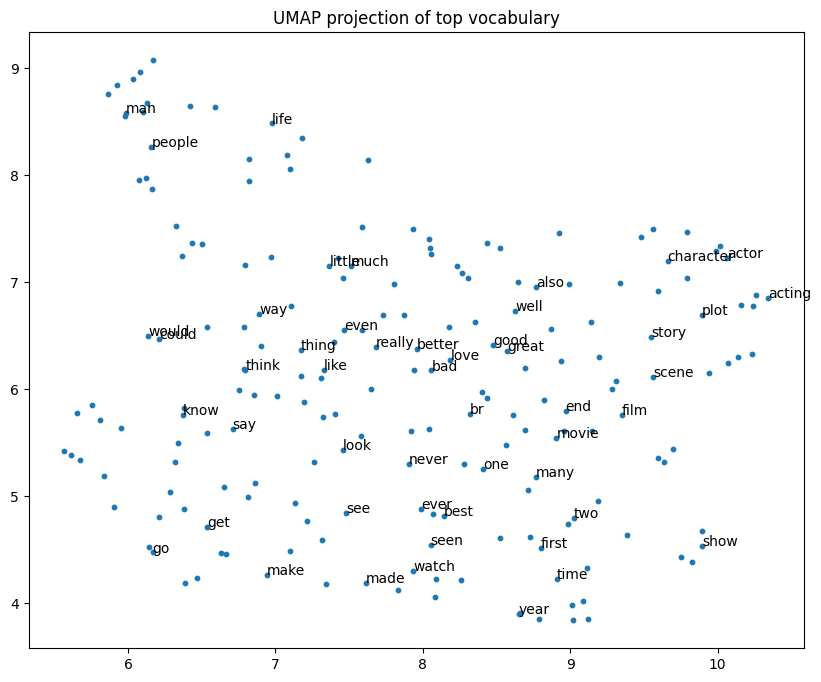

In [7]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap

# choose a vocabulary subset for visualization (frequent words)
vocab = [w for w, v in w2v.wv.key_to_index.items() if w.isalpha()][:200]
vecs = np.array([w2v.wv[w] for w in vocab])

# PCA projection
pca = PCA(n_components=2)
proj_pca = pca.fit_transform(vecs)

plt.figure(figsize=(10,8))
plt.scatter(proj_pca[:,0], proj_pca[:,1], s=10)
for i, w in enumerate(vocab[:50]):
    plt.annotate(w, (proj_pca[i,0], proj_pca[i,1]))
plt.title('PCA projection of top vocabulary')
plt.show()

# UMAP (slower but often more interpretable)
umap_mapper = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
proj_umap = umap_mapper.fit_transform(vecs)

plt.figure(figsize=(10,8))
plt.scatter(proj_umap[:,0], proj_umap[:,1], s=10)
for i, w in enumerate(vocab[:50]):
    plt.annotate(w, (proj_umap[i,0], proj_umap[i,1]))
plt.title('UMAP projection of top vocabulary')
plt.show()

## 8) Convert documents to averaged embeddings and train classifier

Create document vectors by averaging word vectors (ignoring OOV words). Then train a Logistic Regression classifier and report metrics.

100%|██████████| 50000/50000 [00:18<00:00, 2682.30it/s]


Accuracy: 0.8845

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      5000
           1       0.89      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



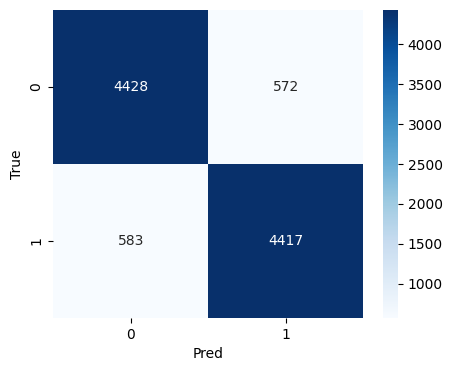

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

EMBEDDING_SIZE = w2v.vector_size

def document_vector(tokens):
    vecs = [w2v.wv[t] for t in tokens if t in w2v.wv]
    if len(vecs) == 0:
        return np.zeros(EMBEDDING_SIZE)
    return np.mean(vecs, axis=0)

X = np.vstack(df['tokens'].progress_apply(document_vector).values)
y = df['label'].map({'positive':1, 'negative':0}).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

## 9) Improvements & next steps

Ideas to improve performance and interpretability:
- Use TF-IDF weighted averaging of embeddings
- Try `fastText` to get vectors for OOV words
- Train a small neural model (CNN / LSTM) on top of embeddings
- Use stratified cross-validation and hyperparameter tuning

We'll save the trained Word2Vec and classifier (via joblib) so you can reuse them without retraining.

## 🔍 Optional: TF‑IDF Weighted Document Embeddings

This section improves the document vector representation.

Instead of simple averaging, each word vector is weighted by its **TF‑IDF score** (term frequency–inverse document frequency), which gives more importance to informative words and reduces the influence of common words like *movie* or *film*.

In [9]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Build TF-IDF model on clean text
tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
tfidf_matrix = tfidf.fit_transform(df['tokens'])
print("TF-IDF vocabulary size:", len(tfidf.vocabulary_))

# Map each word to its idf weight
idf_weights = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

# Weighted document vector function
def document_vector_tfidf(tokens):
    vecs, weights = [], []
    for t in tokens:
        if t in w2v.wv and t in idf_weights:
            vecs.append(w2v.wv[t] * idf_weights[t])
            weights.append(idf_weights[t])
    if len(vecs) == 0:
        return np.zeros(w2v.vector_size)
    return np.sum(vecs, axis=0) / np.sum(weights)

# Compute weighted vectors with progress bar
X_tfidf = np.vstack(df['tokens'].progress_apply(document_vector_tfidf).values)

# Train/test split again
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

clf_tfidf = LogisticRegression(max_iter=2000)
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)
print("TF‑IDF Weighted Accuracy:", accuracy_score(y_test_tfidf, y_pred_tfidf))
print("\nClassification Report:\n", classification_report(y_test_tfidf, y_pred_tfidf))


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF vocabulary size: 89691


100%|██████████| 50000/50000 [00:37<00:00, 1332.76it/s]


TF‑IDF Weighted Accuracy: 0.875

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      5000
           1       0.88      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## 📊 Compare Average vs TF‑IDF Weighted Embeddings

Visualize the classification accuracy of both approaches side‑by‑side to see the improvement (if any).

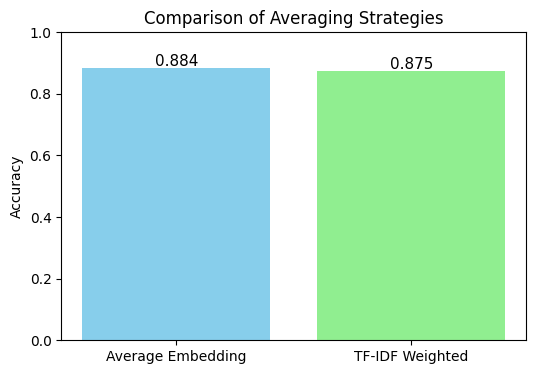

In [10]:

import matplotlib.pyplot as plt

# Collect accuracies
acc_simple = accuracy_score(y_test, y_pred)
acc_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)

plt.figure(figsize=(6,4))
plt.bar(['Average Embedding', 'TF‑IDF Weighted'], [acc_simple, acc_tfidf], color=['skyblue','lightgreen'])
plt.ylabel('Accuracy')
plt.title('Comparison of Averaging Strategies')
for i, acc in enumerate([acc_simple, acc_tfidf]):
    plt.text(i, acc + 0.005, f"{acc:.3f}", ha='center', fontsize=11)
plt.ylim(0, 1)
plt.show()


In [11]:
import joblib
w2v.save('w2v_imdb_improved.model')
joblib.dump(clf, 'logreg_docvec.joblib')
print('Saved w2v_imdb_improved.model and logreg_docvec.joblib')

Saved w2v_imdb_improved.model and logreg_docvec.joblib


## ⚡ Optional: FastText Embeddings

**FastText** extends Word2Vec by representing words as collections of character n‑grams.
This allows it to generate embeddings even for **out‑of‑vocabulary (OOV)** words — extremely useful for noisy or user‑generated text.

Training FastText on the same cleaned and tokenized IMDB data to compare performance.

In [12]:

from gensim.models import FastText

# Train FastText model (same parameters as Word2Vec where possible)
ft_params = {
    'vector_size': 150,
    'window': 5,
    'min_count': 3,
    'workers': 4,
    'epochs': 10,
    'sg': 1  # skip-gram
}

print("Training FastText model...")
ft_model = FastText(sentences=sentences, **ft_params)
ft_model.save('fasttext_imdb.model')
print("FastText model saved to fasttext_imdb.model")

# Example nearest neighbors
examples = ['good', 'movie', 'team', 'great', 'bad']
for word in examples:
    if word in ft_model.wv:
        print(f"\nFastText similar words to '{word}':")
        for sim_word, score in ft_model.wv.most_similar(word, topn=8):
            print(f"  {sim_word}\t{score:.3f}")
    else:
        print(f"'{word}' not in FastText vocabulary")


Training FastText model...
FastText model saved to fasttext_imdb.model

FastText similar words to 'good':
  decent	0.738
  great	0.731
  bad	0.691
  fine	0.679
  allright	0.665
  nice	0.663
  excellent	0.658
  feelgood	0.646

FastText similar words to 'movie':
  film	0.855
  imovie	0.780
  flick	0.747
  horrormovie	0.727
  wp	0.723
  wouldnt	0.699
  gzsz	0.698
  fffc	0.696

FastText similar words to 'team':
  zephyr	0.625
  teammate	0.617
  teamed	0.595
  coach	0.584
  teamster	0.572
  footballer	0.554
  football	0.547
  ragtag	0.542

FastText similar words to 'great':
  excellent	0.785
  wonderful	0.769
  terrific	0.754
  fantastic	0.748
  good	0.731
  fine	0.685
  brilliant	0.683
  outstanding	0.681

FastText similar words to 'bad':
  terrible	0.733
  horrible	0.730
  awful	0.727
  good	0.691
  bade	0.651
  suck	0.637
  lousy	0.636
  godawful	0.633


### 🧠 Evaluate FastText embeddings

Repeat the document vectorization and classification process using the FastText model to see how it performs.

In [13]:

def document_vector_fasttext(tokens):
    vecs = [ft_model.wv[t] for t in tokens if t in ft_model.wv]
    if len(vecs) == 0:
        return np.zeros(ft_model.vector_size)
    return np.mean(vecs, axis=0)

X_ft = np.vstack(df['tokens'].progress_apply(document_vector_fasttext).values)
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X_ft, y, test_size=0.2, random_state=42, stratify=y)

clf_ft = LogisticRegression(max_iter=2000)
clf_ft.fit(X_train_ft, y_train_ft)

y_pred_ft = clf_ft.predict(X_test_ft)
acc_ft = accuracy_score(y_test_ft, y_pred_ft)

print("FastText Accuracy:", acc_ft)
print("\nClassification Report:\n", classification_report(y_test_ft, y_pred_ft))


100%|██████████| 50000/50000 [00:19<00:00, 2512.81it/s]


FastText Accuracy: 0.8826

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      5000
           1       0.88      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### 📈 Compare all three embedding strategies

Let's visualize how **Average**, **TF‑IDF Weighted**, and **FastText** embeddings perform side‑by‑side.

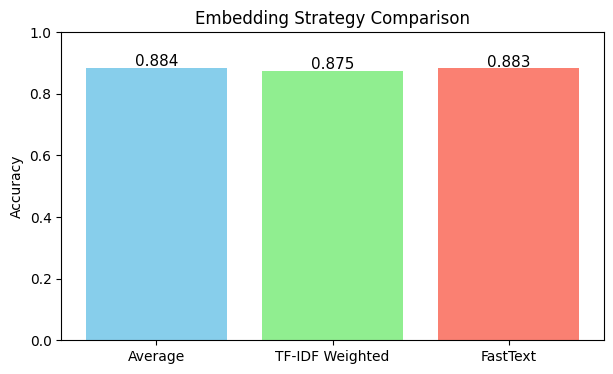

In [14]:

plt.figure(figsize=(7,4))
plt.bar(['Average', 'TF‑IDF Weighted', 'FastText'],
        [acc_simple, acc_tfidf, acc_ft],
        color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Accuracy')
plt.title('Embedding Strategy Comparison')
for i, acc in enumerate([acc_simple, acc_tfidf, acc_ft]):
    plt.text(i, acc + 0.005, f"{acc:.3f}", ha='center', fontsize=11)
plt.ylim(0, 1)
plt.show()
